# BERT OCEAN Classifier — Fine-tuning Notebook

> ce notebook est le modele entrainé par l'équipe.

Il réalise le le **fine-tuning d'un modèle BERT** pour la **classification multi-label** des **traits OCEAN (Big Five)**.

Il suit une structure standard :

1. Import des librairies
2. Configuration a google drive
3. Chargement des données (attention prévoir de changer le chemin d'acces au dataset)
4. Prétraitement, tokenization et split en train et test
5. Défintition du modèle et metrics
6. Config d'entrainement
7. Trainer et entrainement
8. Evalution
9. Sauvegarde du modele et export
10. Exemple (avec l'aide de phrase)

**Rappel : attention au chemin et aux import**



1. Import des librairies

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from datasets import load_dataset, Dataset
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from google.colab import drive


# Selection du gpu si possible

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


2. Config du Google Drive (car notebook traiter sur colab) et **création du dossier sur Drive**

In [3]:
drive.mount('/content/drive')

# creer le dossier de sauvegarde du modele

os.makedirs("./BERT_ocean_classifier/final_model", exist_ok=True)

Mounted at /content/drive


3.  Chargement des données.

  Attention au chemin d'acces. prendre le fichier Ocean concatener des 2 datasets.
  
  En profiter pour rennomer les colonnes en O,C,E,A,N

In [ ]:
df = pd.read_csv('/content/sample_data/concat_ocean.csv')


df = df.rename(columns={
    'Openness': 'O',
    'Conscientiousness': 'C',
    'Extraversion': 'E',
    'Agreeableness': 'A',
    'Neuroticism': 'N',
    'Text': 'text'
})



4. Prétraitement et tokenization.

  point d'attention sur le modele BERT  utilisation d'un **max_length de 512**  et prendre le modele **"bert-base-uncased"**

In [ ]:
#labels
df["labels"] = df[["O", "C", "E", "A", "N"]].values.tolist()

# verifier que chaque éléments de labels soit integer
df["labels"] = df["labels"].apply(lambda x: list(map(int, x)))

# creation du dataset
dataset = Dataset.from_pandas(df[['text', 'labels']])

#tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"],truncation=True,max_length=512,padding=True)
# Tokenization du dataset
dataset = dataset.map(tokenize, batched=True)

#Supprimer la colonne Text
dataset = dataset.remove_columns("text")

#Split dataset en train et test
dataset_train, dataset_test = dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)

5. Définition du modèle. attention nous sommes sur une multiclassification d'ou la sortie sur 5 dans le classifier.

  Nous le nommerons CustomClassifier.

  Preparation d'une fonction de metrics dans lequel nous aurons une fonction sigmoid avec un seuil de décision pour le moment à 0,5.

 rappel suite au différents test nous arretons sur l'epoch 3 qui est le plus pertinent.


In [ ]:
class CustomClassifier(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.backbone = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, 5)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0]
        x = self.dropout(pooled_output)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())

        return {"loss": loss, "logits": logits}

# Initialiser le modèle
model = CustomClassifier()
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

CustomClassifier(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs > 0.5).astype(int)

    results = {}

    #Boucle pour chaque trait du OCEAN
    for i, trait in enumerate(["O", "C", "E", "A", "N"]):
        results[f"{trait}_acc"] = accuracy_score(labels[:, i], preds[:, i])
        results[f"{trait}_f1"] = f1_score(labels[:, i], preds[:, i], zero_division=0)
        results[f"{trait}_precision"] = precision_score(labels[:, i], preds[:, i], zero_division=0)
        results[f"{trait}_recall"] = recall_score(labels[:, i], preds[:, i], zero_division=0)

    # Moyenne global, nous souhaitons avoir une vue global et pour le moment ne pas prédire un trait spécifique.
    results["avg_accuracy"] = np.mean([results[f"{t}_acc"] for t in "OCEAN"])
    results["avg_f1"] = np.mean([results[f"{t}_f1"] for t in "OCEAN"])
    results["avg_precision"] = np.mean([results[f"{t}_precision"] for t in "OCEAN"])
    results["avg_recall"] = np.mean([results[f"{t}_recall"] for t in "OCEAN"])

    return results

6. Configuration d'entrainement

rappel  : suite au différents test nous arretons sur l'epoch 3 qui est le plus pertinent. egalement un learning rate idem que ce que nous avons vu en cours et un weight_decay suite à recommandation de Raphael

In [ ]:
training_args = TrainingArguments(
    output_dir="./BERT_ocean_classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_avg_accuracy",
    greater_is_better=True,
    save_total_limit=1,
    report_to="none"
)

7. Trainer et entrainement

  Nous enregistrons les argmuments du trainers, lancons l'entrainement et enregistrement du modele dans un ".bin" pour le réutiliser.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
)

trainer.train()

#enregistrement du model dans le dossier BERT
torch.save(model.state_dict(), "/content/BERT_ocean_classifier/final_model/pytorch_model.bin")
tokenizer.save_pretrained("/content/BERT_ocean_classifier/final_model")

Epoch,Training Loss,Validation Loss,O Acc,O F1,O Precision,O Recall,C Acc,C F1,C Precision,C Recall,E Acc,E F1,E Precision,E Recall,A Acc,A F1,A Precision,A Recall,N Acc,N F1,N Precision,N Recall,Avg Accuracy,Avg F1,Avg Precision,Avg Recall
1,0.657700,0.623315,0.636364,0.680387,0.627232,0.743386,0.622590,0.709746,0.597148,0.874674,0.601928,0.718049,0.588800,0.920000,0.610193,0.681665,0.604790,0.780928,0.626722,0.628258,0.620596,0.636111,0.619559,0.683621,0.607713,0.791020
2,0.600400,0.596438,0.659780,0.667564,0.679452,0.656085,0.640496,0.640990,0.677326,0.608355,0.630854,0.613833,0.724490,0.532500,0.619835,0.669856,0.625000,0.721649,0.663912,0.687980,0.637441,0.747222,0.642975,0.656045,0.668742,0.653162
3,0.559900,0.589757,0.657025,0.607874,0.750973,0.510582,0.665289,0.703297,0.660550,0.751958,0.669421,0.694656,0.707254,0.682500,0.621212,0.660074,0.634204,0.688144,0.669421,0.694656,0.640845,0.758333,0.656474,0.672112,0.678765,0.678304


('/content/Bert_ocean_classifier/final_model/tokenizer_config.json',
 '/content/Bert_ocean_classifier/final_model/special_tokens_map.json',
 '/content/Bert_ocean_classifier/final_model/vocab.txt',
 '/content/Bert_ocean_classifier/final_model/added_tokens.json')

8. Evaluation avec un matrice de confusion pour validation sur le test

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


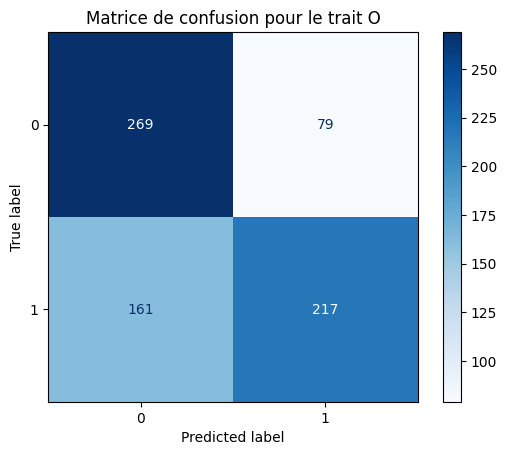

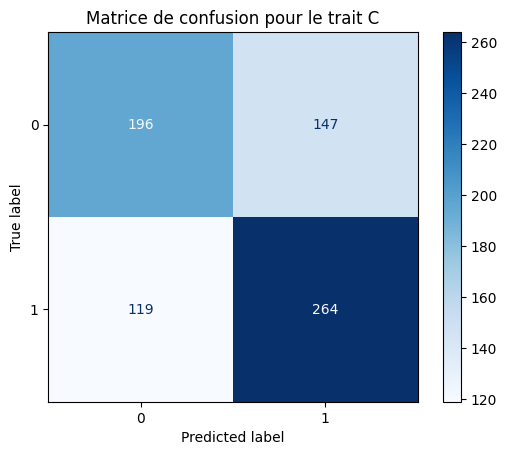

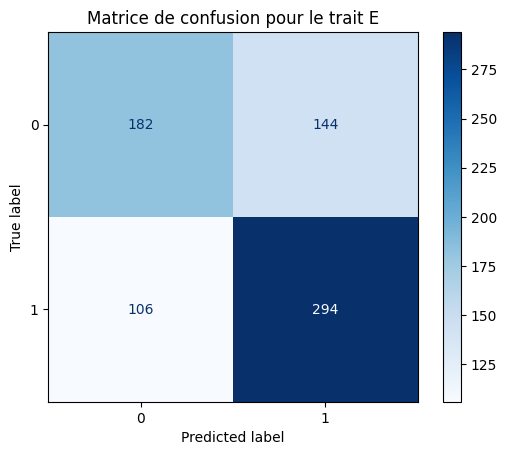

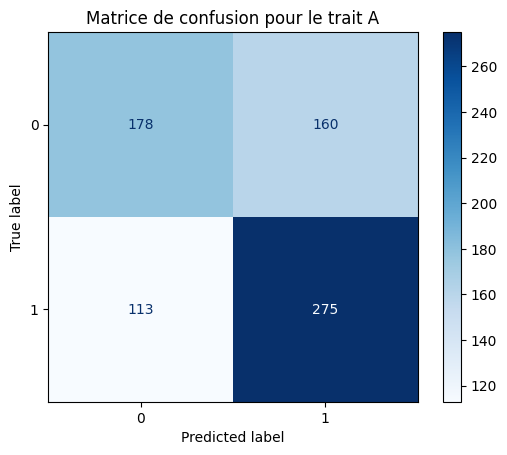

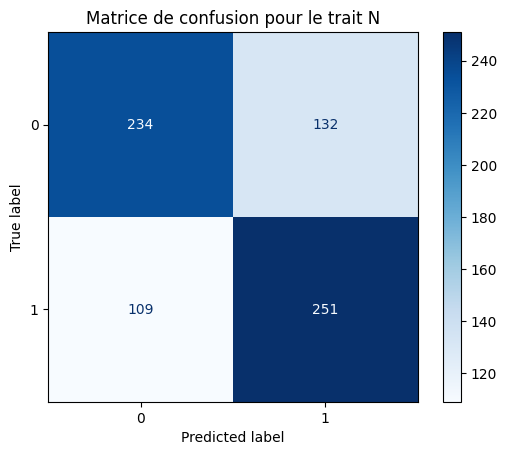

In [ ]:
# matrice de confusion sur chaque trait

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1. Récupération des prédictions
raw_preds = trainer.predict(dataset_test)
logits = raw_preds.predictions
labels = raw_preds.label_ids

# 2. Sigmoid + seuil
probs = 1 / (1 + np.exp(-logits))
preds = (probs > 0.5).astype(int)

# 3. Matrice de confusion par trait
traits = ["O", "C", "E", "A", "N"]

for i, trait in enumerate(traits):
    cm = confusion_matrix(labels[:, i], preds[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Matrice de confusion pour le trait {trait}")
    plt.show()

9. Zip et enregistrement du modele

In [ ]:
!zip -r Bert_ocean_classifier.zip Bert_ocean_classifier
!cp Bert_ocean_classifier.zip /content/drive/MyDrive/


10. Bonus test du model sur un text en anglais.
Pour le test j'ai demandé a plusieurs reprise des textes a GEMINI

In [ ]:
text = "Recently I found myself inspired to start a painting that combined elements of dreams and nature I spent hours blending colors and textures completely absorbed in the creative process This kind of exploration gives me a real sense of freedom and purpose It is like my mind gets to travel  In my daily routine I find satisfaction in organizing my tasks setting goals and ticking them off one by one Planning brings me clarity and helps me stay grounded even when things get hectic  The place I feel most alive is somewhere full of life and people like a bustling cafe with chatter music and the smell of fresh pastries I love being surrounded by energy it fills me up and sparks ideas  There was a time when my close friend was going through something difficult and I stayed up all night talking to them just listening and being there It mattered more than anything else and I would do it again without question  What drives me is the idea that I can bring something good to others through what I do It could be through my job through art or just showing up for people That feeling of connection keeps me moving  When the unexpected hits I often feel overwhelmed at first but I try to sit with it let the emotion pass before I make any decisions I have learned to accept that being sensitive is part of who I am and I do my best to navigate it with kind"

In [ ]:
# Charger le tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Charger le modèle
model_path = "/content/BERT_ocean_classifier/final_model"
model = CustomClassifier()
model.load_state_dict(torch.load(model_path + "/pytorch_model.bin", map_location="cpu"))
model.eval()


#fonction de prédiction

def predict_personality(text, model, tokenizer, threshold=0.5):
    # Tokenisation
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Garde uniquement les clés compatibles avec BERT
    filtered_inputs = {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"]
    }

    # Prédiction
    with torch.no_grad():
        outputs = model(**filtered_inputs)
        logits = outputs["logits"]
        probs = torch.sigmoid(logits)

    preds = (probs > threshold).int().numpy().flatten()

    labels = ["O", "C", "E", "A", "N"]
    prediction_dict = {trait: int(pred) for trait, pred in zip(labels, preds)}
    return prediction_dict, probs.numpy().flatten()



prediction, probs = predict_personality(text, model, tokenizer)
print(prediction)
print(probs)

{'O': 0, 'C': 1, 'E': 0, 'A': 0, 'N': 0}
[0.49060434 0.52971005 0.43918833 0.47574577 0.25182295]
